# Baseline Model Performance

This notebook explores basic models, sampling and imputation strategies in the Kaggle [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk) prediction challenge. The baseline models established in this notebook use application data only and do not include additional credit default and loan data such as bureau information or previous application data.

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import warnings
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

from homeloans.tables import Application,PreviousApplication
from homeloans.tables import get_session
from homeloans.tables import initialise_database
from homeloans.config import DB_DIR

%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# rcParams.update({'figure.autolayout': True})

db_fn = os.path.join(DB_DIR, "home_loans.db")
initialise_database(db_fn, drop=False, echo=False)
session = get_session()

## Loading Data

We load data from the sqlite database set up using the `populate.py` script.

In [4]:
qry_train = session.query(Application).filter(Application.target.isnot(None))  # data which can be used for training
qry_test = session.query(Application).filter(Application.target.is_(None))     # data for which no labels are available, to predict.

appl_train_df = pd.read_sql(qry_train.statement, qry_train.session.bind) 
appl_test_df = pd.read_sql(qry_test.statement, qry_test.session.bind)
train_df = appl_train_df.drop("target", axis=1)
train_labels = appl_train_df["target"].copy()
del appl_train_df

test_df = appl_test_df.drop("target", axis=1)
del appl_test_df

print('Number of observations in train_df:', len(train_df))
print('Number of observations in test_df:', len(test_df))

Number of observations in train_df: 307511
Number of observations in test_df: 48744


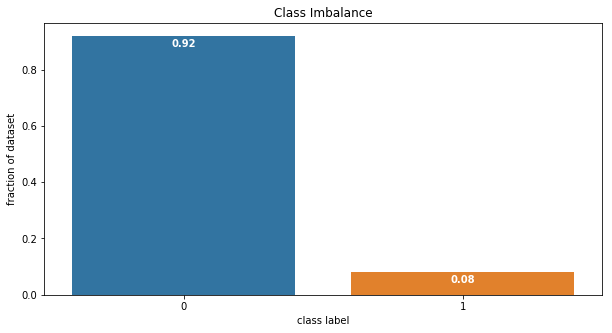

In [41]:
fig, ax = plt.subplots(1, figsize=(10, 5))
counts_df = train_labels.value_counts()/len(train_labels)
sns.barplot(data=counts_df.reset_index(), x='index', y='target', ax=ax)
ax.set_ylabel('fraction of dataset')
ax.set_xlabel('class label')
ax.set_title('Class Imbalance')

ax.text(verticalalignment='top', horizontalalignment='center', x=0, y=counts_df[0]-0.01, s=round(counts_df[0], 2), color='white', fontweight='bold')
ax.text(verticalalignment='top', horizontalalignment='center', x=1, y=counts_df[1]-0.01, s=round(counts_df[1], 2), color='white', fontweight='bold');

## A Look at Missing Data

As we will see, there are quite a number of features for which at least some fraction of data is missing.

In [14]:
print('Number of features with missing data:', (train_df.isnull().sum() > 0).sum())

Number of features with missing data: 69


Below plot shows the fraction of missing data for all 69 indicators for which at least one observation is missing.

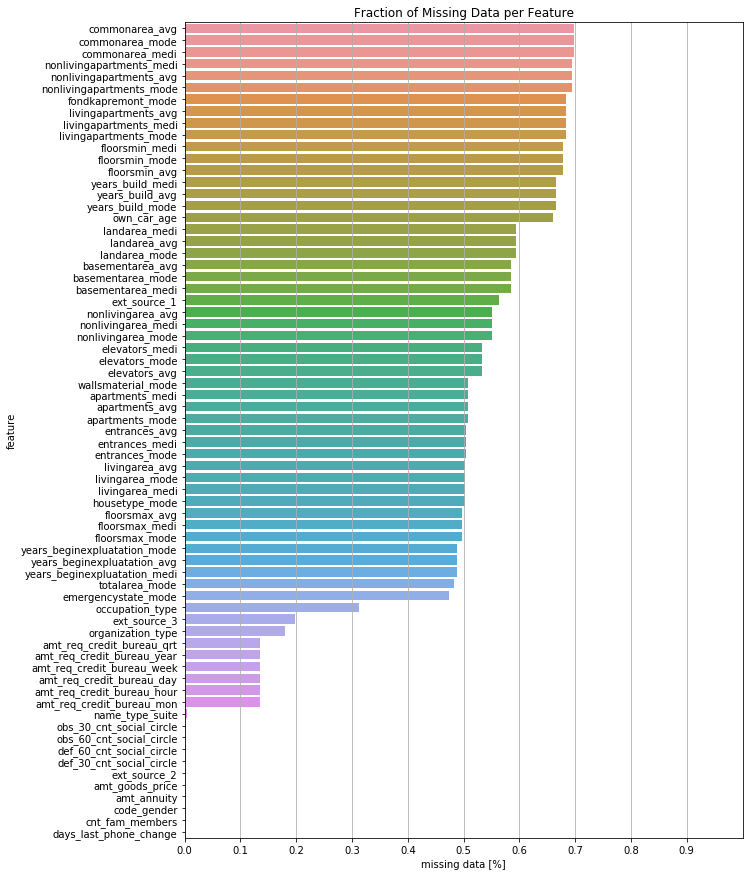

In [17]:
missing_per_feature = train_df.isnull().sum()/len(train_df)
missing_df = pd.DataFrame(missing_per_feature.sort_values(ascending=False)).reset_index()
missing_df = missing_df[missing_df[0] > 0]

fig, ax = plt.subplots(1, figsize=(10, 15))
sns.barplot(x=0, y='index', data=missing_df)
ax.set_xlim([0, 1])
ax.set_xlabel('missing data [%]')
ax.set_ylabel('feature')
ax.set_title('Fraction of Missing Data per Feature')
ax.set_xticks(np.arange(0, 1, 0.1))
ax.xaxis.grid();

Below, we draw a histogram depicting the empirical distribution of the number of missing features per each individual training example. As we can see, a peak is observed around 50 missing features, highlighting that a significant fraction of data, in fact, is missing multiple features at once.

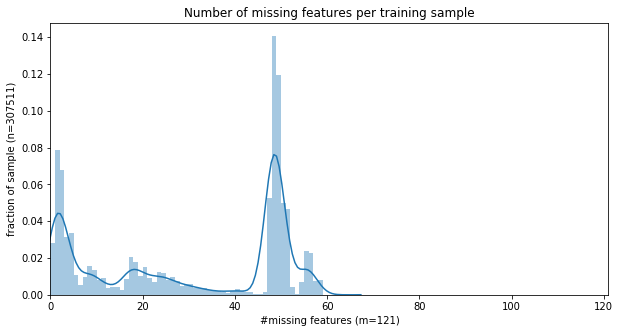

In [18]:
fig, ax = plt.subplots(1, figsize=(10, 5))
sns.distplot(train_df.isnull().sum(axis=1), ax=ax, bins=np.arange(0, len(train_df.columns)))
ax.set_title('Number of missing features per training sample')
ax.set_xlabel('#missing features (m=%d)' % len(train_df.columns))
ax.set_ylabel('fraction of sample (n=%d)' % len(train_df));
ax.set_xlim([0, len(train_df.columns)]);

## A Basic Data Pre-processing Pipeline

Below we implement a basic data processing pipeline using `sklearn` transformers. The steps we take are as follows (depending on whether a feature has missing data and whether it is numerical or categorical).

1. Split the data into 66.6% training and 33.3% test/validation data
2. Impute missing data (for categorical values we take the most common, for numerical data we take the median)
3. Convert categorical values to `pd.Categorical` and use `get_dummies` to create a one-hot encoding (for classifiers which rely on data not being collinear, we use the `drop_first=True` option to not artificially create collinearity from categorical features.
4. Standardise numerical data ($\mu=0, \sigma=1$)
5. Convert boolean features to $0$ and $1$s.

Additionally, we implement one-off transformers for `days_employed` to remove large positive values (which seem to be an error, we just replace them with `NaN` and then impute the median. Also, we convert weekdays to discrete integers in $[0, 6]$.


The cell below implements all the transformers relied on in subsequent steps:

In [44]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]
    
    
class DropPositiveValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.concat([pd.Series(X[col].map(lambda x: np.NaN if x > 0 else x), name=col) for col in X], axis=1)

class DataFrameConvertCategories(BaseEstimator, TransformerMixin):
    def __init__(self, missing_vals=None):
        self._cat_codes = {}
        self._missing_vals = missing_vals or tuple()
        
    def fit(self, X, y=None):
        for col in X:
            cat_map = [col_val for col_val in X[col].dropna().unique() if col_val not in self._missing_vals]
            self._cat_codes[col] = cat_map
        return self
    
    def transform(self, X, y=None):
        cat_cols = []
        for col in X:
            cat_cols.append(pd.Series(pd.Categorical(X[col], categories=self._cat_codes[col]), name=col))
        return pd.concat(cat_cols, axis=1)
    
    
class DataFrameOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, **options):
        self._pd_dummies_option = options or {}
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.get_dummies(X, **self._pd_dummies_option)
    
    
class PandasToNumpy(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.values
    

class DataFrameBooleanToNumerical(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_dtype=np.float):
        self._num_dtype = numerical_dtype
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.astype(self._num_dtype)
    

class ImputeMostCommonValue(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._max_vals = {}
        
    def fit(self, X, y=None):
        for col in X:
            self._max_vals[col] = X[col].value_counts().idxmax()
        return self
    
    def transform(self, X, y=None):
        return pd.concat([pd.Series(X[col].fillna(self._max_vals[col]), name=col) for col in X], axis=1)
        

class WeekdayToNumerical(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._val_map = {"MONDAY": 0,
                         "TUESDAY": 1,
                         "WEDNESDAY": 2,
                         "THURSDAY": 3,
                         "FRIDAY": 4,
                         "SATURDAY": 5,
                         "SUNDAY": 6}
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.concat([pd.Series(X[col].map(self._val_map), name=col, dtype=np.int) for col in X], axis=1)

Next, we set up the pipelines and categorise individual features:

In [54]:
from sklearn.preprocessing import Imputer, StandardScaler

drop_first = True  # set to True if the applied model cannot work with collinearity among features (e.g. naive bayes or logistic regression)

categorical_cols = ['name_contract_type',
                    'code_gender',
                    'name_type_suite',
                    'name_income_type',
                    'name_education_type',
                    'name_family_status',
                    'name_housing_type',
                    'occupation_type',
                    'organization_type',
                    'wallsmaterial_mode',
                    'emergencystate_mode',
                    'housetype_mode',
                    'fondkapremont_mode']

boolean_cols = ['flag_own_car',
                'flag_own_realty',
                'flag_mobil',
                'flag_emp_phone',
                'flag_work_phone',
                'flag_cont_mobile',
                'flag_phone',
                'flag_email',
                'flag_document_2',
                'flag_document_3',
                'flag_document_4',
                'flag_document_5',
                'flag_document_6',
                'flag_document_7',
                'flag_document_8',
                'flag_document_9',
                'flag_document_10',
                'flag_document_11',
                'flag_document_12',
                'flag_document_13',
                'flag_document_14',
                'flag_document_15',
                'flag_document_16',
                'flag_document_17',
                'flag_document_18',
                'flag_document_19',
                'flag_document_20',
                'flag_document_21']

int_numerical_cols = ['cnt_children',
                      'days_birth',
                      'days_employed',
                      'days_registration',
                      'days_id_publish',
                      'own_car_age',
                      'cnt_fam_members',
                      'region_rating_client',
                      'region_rating_client_w_city',
                      'hour_appr_process_start',
                      'reg_region_not_live_region',
                      'reg_region_not_work_region',
                      'live_region_not_work_region',
                      'reg_city_not_live_city',
                      'reg_city_not_work_city',
                      'live_city_not_work_city',
                      'obs_30_cnt_social_circle',
                      'def_30_cnt_social_circle',
                      'obs_60_cnt_social_circle',
                      'def_60_cnt_social_circle',
                      'days_last_phone_change',
                      'amt_req_credit_bureau_hour',
                      'amt_req_credit_bureau_day',
                      'amt_req_credit_bureau_week',
                      'amt_req_credit_bureau_mon',
                      'amt_req_credit_bureau_qrt',
                      'amt_req_credit_bureau_year']

float_numerical_cols = ['amt_income_total',
                        'amt_credit',
                        'amt_annuity',
                        'amt_goods_price',
                        'region_population_relative',
                        'ext_source_1',
                        'ext_source_2',
                        'ext_source_3',
                        'apartments_avg',
                        'basementarea_avg',
                        'years_beginexpluatation_avg',
                        'years_build_avg',
                        'commonarea_avg',
                        'elevators_avg',
                        'entrances_avg',
                        'floorsmax_avg',
                        'floorsmin_avg',
                        'landarea_avg',
                        'livingapartments_avg',
                        'livingarea_avg',
                        'nonlivingapartments_avg',
                        'nonlivingarea_avg',
                        'apartments_mode',
                        'basementarea_mode',
                        'years_beginexpluatation_mode',
                        'years_build_mode',
                        'commonarea_mode',
                        'elevators_mode',
                        'entrances_mode',
                        'floorsmax_mode',
                        'floorsmin_mode',
                        'landarea_mode',
                        'livingapartments_mode',
                        'livingarea_mode',
                        'nonlivingapartments_mode',
                        'nonlivingarea_mode',
                        'apartments_medi',
                        'basementarea_medi',
                        'years_beginexpluatation_medi',
                        'years_build_medi',
                        'commonarea_medi',
                        'elevators_medi',
                        'entrances_medi',
                        'floorsmax_medi',
                        'floorsmin_medi',
                        'landarea_medi',
                        'livingapartments_medi',
                        'livingarea_medi',
                        'nonlivingapartments_medi',
                        'nonlivingarea_medi',
                        'totalarea_mode']

weekday_start_pipeline = Pipeline([
    ('selector', DataFrameSelector(["weekday_appr_process_start"])),
    ('weekday_converter', WeekdayToNumerical()),
    ('impute_median', Imputer(strategy="median")),
    ('scale', StandardScaler())
])

days_employed_pipeline = Pipeline([
    ('selector', DataFrameSelector(['days_employed'])),
    ('positive_remover', DropPositiveValues()),
    ('impute_median', Imputer(strategy="median")),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_cols)),
    ('impute_most_common', ImputeMostCommonValue()),
    ('to_categorical_df', DataFrameConvertCategories()),
    ('to_dummies', DataFrameOneHotEncoder(drop_first=False))
])

boolean_pipeline = Pipeline([
    ('selector', DataFrameSelector(boolean_cols)),
    ('impute_most_common', ImputeMostCommonValue()),
    ('to_numerical', DataFrameBooleanToNumerical())
])

numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(int_numerical_cols + float_numerical_cols)),
    ('impute_median', Imputer(strategy="median")),
    ('scale', StandardScaler())
])

full_pipeline = FeatureUnion(transformer_list=[
        ('days_employed_pl', days_employed_pipeline),
        ('weekday_pipeline', weekday_start_pipeline),
        ('categorical_pipeline', categorical_pipeline),
        ('boolean_pipeline', boolean_pipeline),
        ('numerical_pipeline', numerical_pipeline)
])

Before we can actually apply the data processing pipeline, we have to split our data into training and validation sets. For this we use `sklearn`'s `test_train_split`. We make use of stratified sampling to not affect the class (im)balance in the training and validation data sets.

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df, train_labels.values, test_size=1/3, random_state=31337)

print("Positive observations in the train set (n=%d):" % len(X_train), y_train.sum()/len(y_train)*100, "%")
print("Positive observations in the test set (n=%d):" % len(X_test), y_test.sum()/len(y_test)*100, "%")

Positive observations in the train set (n=205007): 8.063139307438282 %
Positive observations in the test set (n=102504): 8.092367127136502 %


In [56]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

## Building a Naive Bayes Model and Recording Baseline Performance Metrics

Below we train our first model - a simple Gaussian Naive Bayes (`GaussianNB`) classifier. The competition uses Area Under Curve (AUC) as its evaluation metric. Given the class imbalances, we will report not only the AUC but also draw a precision-recall curve and calculate F1-scores.

In [58]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# training performance
nb_tr_y = naive_bayes.predict(X_train)
nb_tr_p = naive_bayes.predict_proba(X_train)

# test performance
nb_te_y = naive_bayes.predict(X_test)
nb_te_p = naive_bayes.predict_proba(X_test)

In [106]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score, roc_auc_score, precision_recall_curve

def plot_roc_curve(y_actual, y_predicted_p, model_name, ax=None):
    """Takes as input the actual class labels and the predicted class probabilities to draw ROC-curve.
    """
    fpr, tpr, _ = roc_curve(y_actual, y_predicted_p[:,1])
    roc_auc = auc(fpr, tpr)
    if not ax:
        fig, ax = plt.subplots(1)
    ax.plot(fpr, tpr, lw=2, label='ROC %s (AUC=%0.2f)' % (model_name, roc_auc))
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right')
    return ax
    
def plot_precision_recall(y_actual, y_predicted_p, y_predicted, model_name, ax=None):
    prec, rec, _ = precision_recall_curve(y_actual, y_predicted_p[:,1])
    if not ax:
        fig, ax = plt.subplots(1)
    ax.step(rec, prec, where='post', label='%s (F1=%0.2f)' % (model_name, f1_score(y_actual, y_predicted)))
    ax.fill_between(rec, prec, step='post', alpha=0.2)
    
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc='lower right')
    return ax

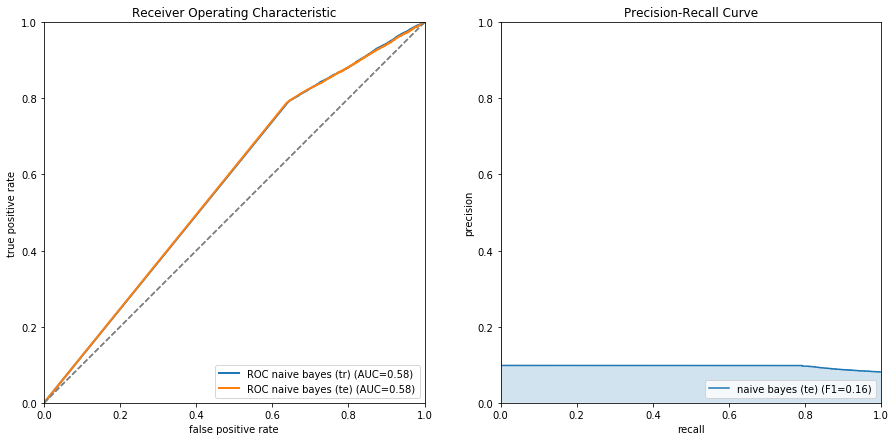

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plot_roc_curve(y_train, nb_tr_p, 'naive bayes (tr)', ax[0])
plot_roc_curve(y_test, nb_te_p, 'naive bayes (te)', ax[0])
plot_precision_recall(y_test, nb_te_p, nb_te_y, 'naive bayes (te)', ax[1]);